In [102]:
# Import libraries
import torch
import numpy as np
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
from PIL import Image
import random
import cv2

# Import other complementary scripts
from models.pl_inference import ReidPrediction
from datasets.dataloader import ReidDataModule
from utils.cosine_similarity import cosine_similarity
from utils.re_ranking import re_ranking

In [103]:
#Parameteres
class Config():
    cat_testing_dir = 'data/sample/images/'
    cat_anno_test_file = 'data/sample/sample_anno.csv'
    evaluation_file = 'data/sample/gt_sample.json'
    number_workers = 8
    num_classes = 300
    batch_size_test = 1
    size_full_image = (256,512)
    embeddings = 2560
    arcface = False
    backbone = 'resnet152'
    deterministic = [True, "warn"]
    precision = "16-mixed"
    trained_model = 'best_model.pth'

# Creating dataloader
cat_data = ReidDataModule(data_directory=Config(),
                            batch_size_test = Config().batch_size_test,
                            num_workers= Config().number_workers, 
                            size_full_image = Config().size_full_image)
# Call the setup method
cat_data.setup()

# Create the model
eval_model = ReidPrediction(
    backbone_model = Config().backbone,
    number_classes = Config().num_classes, 
    embedding_size = Config().embeddings,
    arcface = False)

# Create the trainer
trainer = Trainer(accelerator='gpu', logger = False, 
                enable_checkpointing=False, 
                precision = Config().precision, 
                deterministic = Config().deterministic)

# Load the weights and biases
eval_model.full_image_model.load_state_dict(torch.load('pretrained_weights/' + Config().trained_model))

# Evaluation of model
predictions = trainer.predict(eval_model,cat_data.test_dataloader())


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 62.21it/s]


In [104]:
# Re-ranking
 
# Create a empty matrix
dist_matrix = np.zeros((len(eval_model.pred_img_id),len(eval_model.pred_img_id)))

for query_im in range(0, len(eval_model.pred_img_id)):
    for collection_im in range(0,len(eval_model.pred_img_id)):
        dist_matrix[query_im,collection_im] = cosine_similarity(eval_model.pred_embeddings[query_im].cpu().numpy(), eval_model.pred_embeddings[collection_im].cpu().numpy())

# Get the reranked distance matrix
reranked_dist = re_ranking(dist_matrix, dist_matrix, dist_matrix, k1=20, k2=6, lambda_value=0.3)

In [105]:
# Check how many entities we have
anno_sample = pd.read_csv(Config.cat_anno_test_file)

# Have the name of images
img_ids = eval_model.pred_img_id

IMAGES_PATH = 'data/sample/images/'

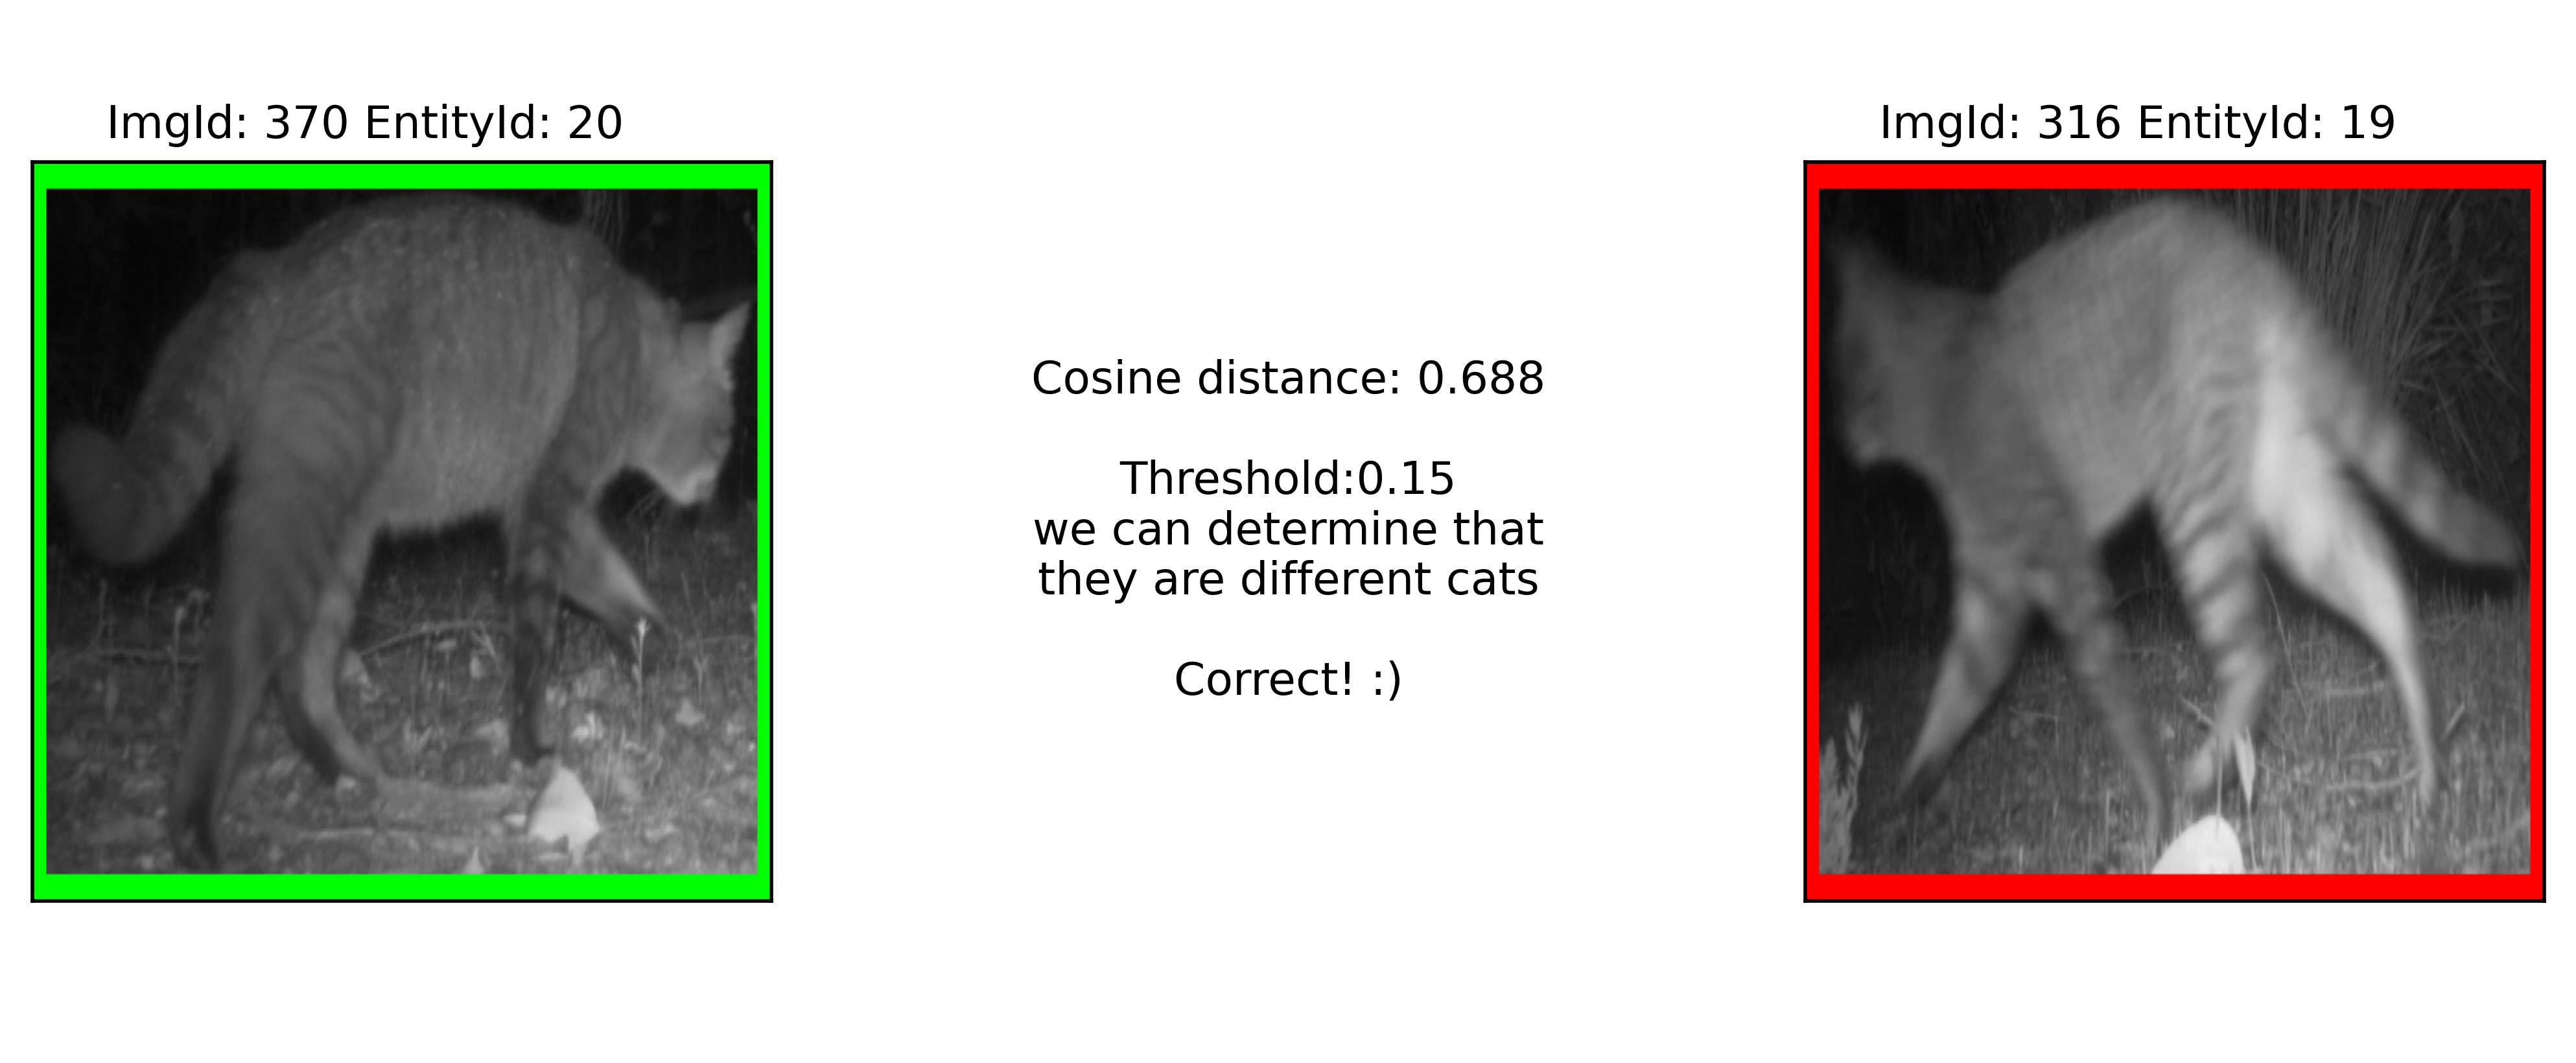

In [106]:
# Create main plot
fig, axes = plt.subplots(1, 3, figsize=(10, 4),dpi = 500)

# Function to add a border to an image
def add_border(image, border_color, border_width):
    bordered_image = cv2.copyMakeBorder(image, border_width, border_width, border_width, border_width, cv2.BORDER_CONSTANT, value=border_color)
    return bordered_image

# Specify the border color
border_width = 10

# Initialize an empty image object in the first subplot
img_obj1 = axes[0].imshow(np.zeros((1, 1, 3), dtype=np.uint8))
axes[0].set(xticks = [], yticks = [])

# Define title
title_text1 = axes[0].text(0.1, 1.05, "", transform=axes[0].transAxes, va='center')

# Remove the ticks in the middle plot
axes[1].set(xticks = [], yticks = [])
axes[1].axis('off')

# Define title
title_text_ = axes[1].text(0.5, 0.5, "", transform=axes[1].transAxes, va='center', ha = 'center')

# Initialize an empty image object in the first subplot
img_obj2 = axes[2].imshow(np.zeros((1, 1, 3), dtype=np.uint8))
axes[2].set(xticks = [], yticks = [])

# Define title
title_text2 = axes[2].text(0.1, 1.05, "", transform=axes[2].transAxes, va='center')

# Function to update the image and scatterplot in each animation frame
def update(frame):
    
    # Select a random number
    r1, r2 = random.sample(range(len(img_ids)), 2)

    class_r1 = anno_sample['entityid'][r1]
    class_r2 = anno_sample['entityid'][r2]
    
    # Define data for cat images
    img1 = Image.open(IMAGES_PATH + str(img_ids[r1]) + '.jpg')
    img1 = img1.resize((512,256))

    # Add a border to each image
    img1 = add_border(np.array(img1), (0,255,0), border_width)
    img_obj1.set_data(img1)  

    # Set the title to the name of the current image
    title_text1.set_text('ImgId: ' + str(img_ids[r1]) + ' EntityId: ' + str(anno_sample['entityid'][r1]))

    # Return the distance
    threshold = 0.15
    if reranked_dist[r1,r2] < threshold:
        result_similarity = 'they are the same cat'
        if class_r1 == class_r2:
            evaluation = 'Correct! :)'
        else:
            evaluation = 'Failure! :('
    else:
        result_similarity = 'they are different cats'
        if class_r1 != class_r2:
            evaluation = 'Correct! :)'
        else:
            evaluation = 'Failure! :('


    title_text_.set_text('Cosine distance: ' + str(round(reranked_dist[r1,r2],3)) +  "\n\n" + "Threshold:" + str(threshold) +  "\n" + "we can determine that" + "\n" + result_similarity + "\n\n" + evaluation)

    # Define data for cat images
    img2 = Image.open(IMAGES_PATH + str(img_ids[r2]) + '.jpg')
    img2 = img2.resize((512,256))
    # Add a border to each image
    if class_r1 == class_r2:
        colour_border2 = (0,255,0)

    else:
        colour_border2 = (255,0,0)

    img2 = add_border(np.array(img2), colour_border2, border_width)
    img_obj2.set_data(img2)  

    # Set the title to the name of the current image
    title_text2.set_text('ImgId: ' + str(img_ids[r2]) + ' EntityId: ' + str(anno_sample['entityid'][r2]))

    # Return the plots
    return (img_obj1, img_obj2)

# Create an animation that updates the image and scatterplot
anim = animation.FuncAnimation(fig=fig, func=update, frames=len(img_ids), interval=1500)

# Create animation
anim.save(filename="images/check_similarities.gif", writer="pillow")

# Show the animation
plt.show()
